# CL futures options backtest analysis

In [27]:
import pandas as pd
import numpy as np
from pandas.tseries.offsets import BDay
import datetime

import time, sys
from IPython.display import clear_output

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Option pricing
import mibian

## Data 
Historical daily crude oil price data is downloaded from Investing.com.

In [28]:
# Read underlying price data
df_undl = pd.read_csv("Crude Oil WTI Futures Historical Data.csv")
df_undl['Date_index'] = pd.to_datetime(df_undl['Date'])
df_undl = df_undl.set_index('Date_index')
df_undl.drop(['Date', 'Change %', 'Vol.'], axis=1, inplace=True)
df_undl.rename({'Price': "C", 'Open': "O",'High': "H",'Low': "L"}, axis='columns', inplace=True)
df_undl = df_undl.iloc[::-1]

# Set list of strikes
sr_strike = pd.Series(np.concatenate([np.arange(10,124,0.5),[124, 125],np.arange(127.5,172.5,2.5)])) 

Historical implied volatility is proxied by daily OVX data, also downloaded from Investing.com.

In [29]:
# Read implied volatility data
df_iv = pd.read_csv("CBOE Crude Oil Volatility Historical Data.csv")
df_iv['Date_index'] = pd.to_datetime(df_iv['Date'])
df_iv = df_iv.set_index('Date_index')
df_iv.drop(['Date', 'Change %', 'Vol.'], axis=1, inplace=True)
df_iv.rename({'Price': "C_iv", 'Open': "O_iv",'High': "H_iv",'Low': "L_iv"}, axis='columns', inplace=True)
df_iv = df_iv.iloc[::-1]

As a proxy for the risk free rate, monthly LIBOR data is used. 

In [30]:
# Read LIBOR data
df_libor = pd.read_csv("libor.csv", sep=';')
df_libor['Date_index'] = df_libor['year'].astype(str) + "-" + df_libor['month'].astype(str)
df_libor['Date_index'] = pd.to_datetime(df_libor['Date_index'])
df_libor = df_libor.set_index('Date_index')

Put together all the data.

In [31]:
# Add enrichment data to main dataframe
df_undl['r'] = df_libor['avg']
df_undl['IV'] = df_iv['C_iv']
df_undl.fillna(method='ffill', inplace=True)
df_undl.dropna(inplace=True)

## Expirations
For each day we determine the standard monthly expiration that is closest to 30 days.

In [32]:
# Compute standard expirations: 7 business day before 26th in the month prior to contract month.
list_month = df_undl.resample('m').last().index
list_std_exp = [datetime.datetime(m.year, m.month, 26) - BDay(7) for m in list_month]
mask_std_exp = df_undl.index.isin(list_std_exp)
df_undl.loc[mask_std_exp, "Exp"] = 'std'

# Compute days until standard expiration
df_undl.loc[mask_std_exp, 'Next exp date (std)'] = df_undl.index[mask_std_exp]
df_undl.loc['2019-06-25', 'Next exp date (std)'] = pd.to_datetime('2019-07-17')
df_undl['Next exp date (std)'] = df_undl['Next exp date (std)'].fillna(method='bfill')

# Compute days until second standard expiration
list_shifted = df_undl.index[mask_std_exp].tolist()
list_shifted.pop(0)
list_shifted.append(pd.NaT)
df_undl.loc[mask_std_exp, 'Second next exp date (std)'] = pd.to_datetime(list_shifted)
df_undl.loc['2019-06-25', 'Second next exp date (std)'] = pd.to_datetime('2019-08-15')
df_undl.loc['2019-06-17', 'Second next exp date (std)'] = pd.to_datetime('2019-07-17')
df_undl['Second next exp date (std)'] = df_undl['Second next exp date (std)'].fillna(method='bfill')

# Get T closest to 30 days
mask_first = np.abs((df_undl['Next exp date (std)'] - df_undl.index).dt.days - 30) < np.abs((df_undl['Second next exp date (std)'] - df_undl.index).dt.days - 30)
df_undl.loc[mask_first, 'T_30'] = (df_undl.loc[mask_first, 'Next exp date (std)'] - df_undl.loc[mask_first].index).dt.days
df_undl.loc[mask_first, 'Chosen exp'] = df_undl.loc[mask_first, 'Next exp date (std)']
df_undl.loc[~mask_first, 'T_30'] = (df_undl.loc[~mask_first, 'Second next exp date (std)'] - df_undl.loc[~mask_first].index).dt.days
df_undl.loc[~mask_first, 'Chosen exp'] = df_undl.loc[~mask_first, 'Second next exp date (std)']

In [33]:
# Compute weekly expirations: Friday of each week. (If it is holiday, it may be earlier, but we do not care now...)
mask_weekly_exp = df_undl.index.day_name() == "Friday"
df_undl.loc[mask_weekly_exp, "Exp"] = 'weekly'

## Analyse returns
In this section we compute based on historical data the distribution of 1 month returns.  

In [34]:
# Compute returns
df_undl['R_1'] = df_undl['C'].pct_change(periods=1)
df_undl['R_20'] = df_undl['C'].pct_change(periods=20)
df_undl['R_30'] = df_undl['C'].pct_change(periods=30)
df_undl['R_40'] = df_undl['C'].pct_change(periods=40)

The plots show that if we open a short strangle at 0.1 delta, then we need approx. 15% movement in a month to reach one of the strikes.  

No handles with labels found to put in legend.
No handles with labels found to put in legend.


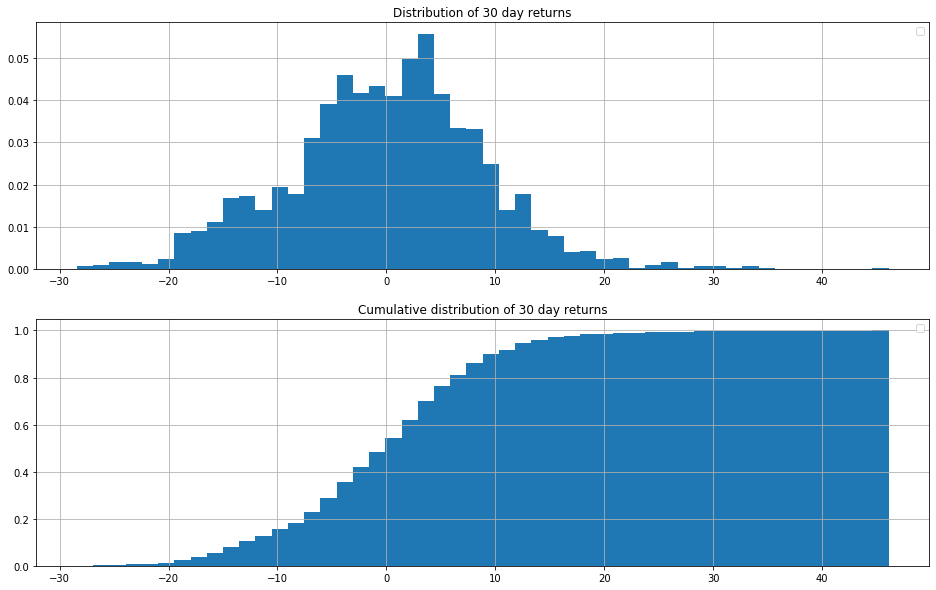

In [35]:
fig, axes = plt.subplots(2, figsize=(16,10))

# Plot 0
axes[0].hist(df_undl['R_20'].dropna() * 100, bins=50, density=True, cumulative=False)
axes[0].set_title('Distribution of 30 day returns')

# Plot 1 
axes[1].hist(df_undl['R_20'].dropna() * 100, bins=50, density=True, cumulative=True)
axes[1].set_title('Cumulative distribution of 30 day returns')

for ax in axes.flat:
    ax.legend()
    ax.grid()

## Simulation
Here we simulate writing a short strangle
- for 30 days (regardless of expiration dates, this is just approximation). I call this the daily simulation. 
- until the expiration closest to 30 days. I call this the monthy simulation.

In [36]:
def find_strikes(row, delta, T, exp="daily"):
    """ 
    Find the strikes to use for a short strangle, given the delta. 
    The function uses simulated data created by pricing algorithm.
    """
    clear_output(wait=True)
    print("Processing {}\r".format(row.name.strftime("%Y-%m-%d")))
    S = row['C']
    r = row['r']
    iv = row['IV'] 
    
    # Prepare strike lists
    mask_call = sr_strike > S
    mask_put = sr_strike < S
    sr_call = sr_strike[mask_call] 
    sr_put = sr_strike[mask_put][::-1]
    
    # Find expiration
    if exp == "std":
        T = row['T_30']
    
    # Search Call strike
    for X in sr_call:
        opt = mibian.BS([S, X, r, T], volatility=iv)
        if opt.callDelta < delta:
            call_X = X
            call_delta = opt.callDelta
            call_price = opt.callPrice
            #print("Found strike {} with Delta {}".format(call_X, call_delta))
            break
            
    # Search Put strike
    for X in sr_put:
        opt = mibian.BS([S, X, r, T], volatility=iv)
        if opt.putDelta > -delta:
            put_X = X
            put_delta = opt.putDelta
            put_price = opt.putPrice
            #print("Found strike {} with Delta {}".format(put_X, put_delta))
            break
           
    return (call_X, put_X, call_delta, put_delta, call_price, put_price)

In [37]:
# Generate option data (THIS TAKES A FEW MINUTES!)
# 0.1 Delta for 30 days
sr_const_30 = df_undl.apply(lambda x: find_strikes(x, 0.1, 30), axis=1)

# 0.1 Delta until standard expiration closest to 30 days
sr_standard = df_undl.apply(lambda x: find_strikes(x, 0.1, 30, 'std'), axis=1)

Processing 2019-06-25


In [38]:
# Enrich main dataframe with simulated data
df_const_30 = pd.DataFrame(sr_const_30.tolist(), columns=['X_call_const_30', 'X_put_const_30', 'Delta_call_const_30', 'Delta_put_const_30', 'Price_call_const_30', 'Price_put_const_30'], index=df_undl.index)
df_undl = pd.concat([df_undl, df_const_30], axis=1, sort=False)

df_standard = pd.DataFrame(sr_standard.tolist(), columns=['X_call_standard', 'X_put_standard', 'Delta_call_standard', 'Delta_put_standard', 'Price_call_standard', 'Price_put_standard'], index=df_undl.index)
df_undl = pd.concat([df_undl, df_standard], axis=1, sort=False)

## Analysis
Here we compute width of the written channel and the received premium for both daily and monthly simulations, and plot them.  

In [39]:
df_undl['width_const_30'] = df_undl['X_call_const_30'] - df_undl['X_put_const_30']
df_undl['premium_const_30'] = df_undl['Price_call_const_30'] + df_undl['Price_put_const_30']

df_undl['width_standard'] = df_undl['X_call_standard'] - df_undl['X_put_standard']
df_undl['premium_standard'] = df_undl['Price_call_standard'] + df_undl['Price_put_standard']

Daily simulation plots.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


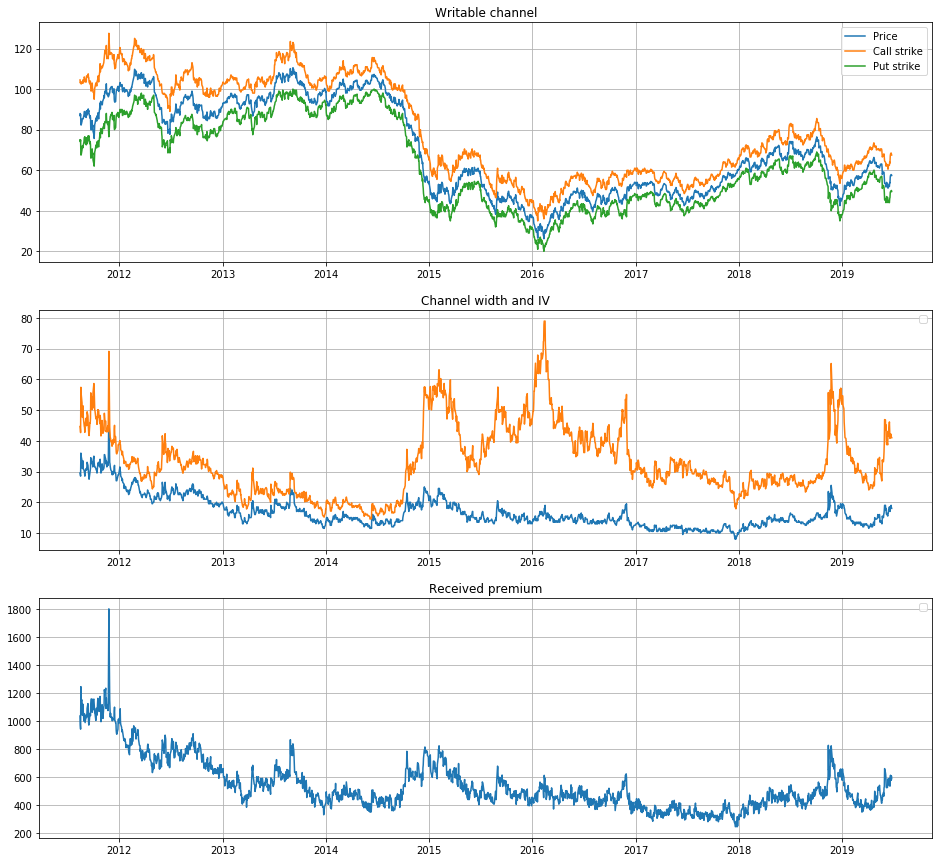

In [40]:
fig, axes = plt.subplots(3, figsize=(16,15))

# Plot 0
axes[0].plot(df_undl['C'], linestyle='-', label="Price")
axes[0].plot(df_undl['X_call_const_30'], linestyle='-', label="Call strike")
axes[0].plot(df_undl['X_put_const_30'], linestyle='-', label="Put strike")
axes[0].set_title('Writable channel')

# Plot 1 
axes[1].plot(df_undl['width_const_30'])
axes[1].plot(df_undl['IV'])
axes[1].set_title('Channel width and IV')

# Plot 2 
axes[2].plot(df_undl['premium_const_30'] * 1000)
axes[2].set_title('Received premium')

for ax in axes.flat:
    ax.legend()
    ax.grid()

Monthly simulation plots.

No handles with labels found to put in legend.
No handles with labels found to put in legend.


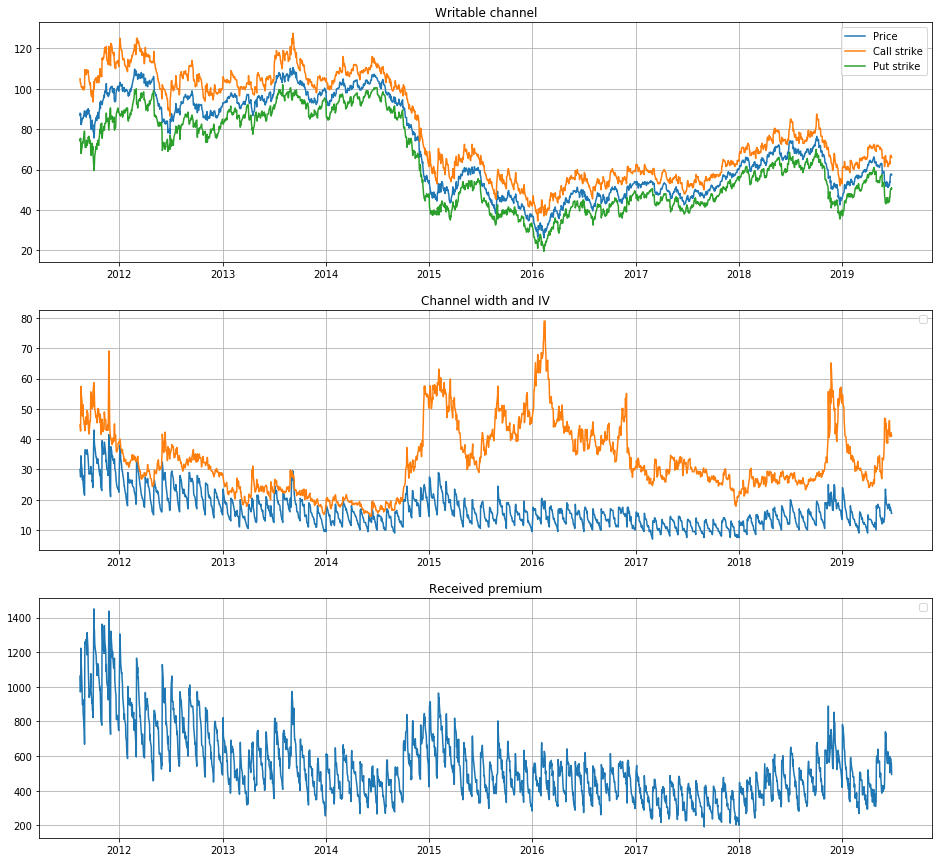

In [41]:
fig, axes = plt.subplots(3, figsize=(16,15))

# Plot 0
axes[0].plot(df_undl['C'], linestyle='-', label="Price")
axes[0].plot(df_undl['X_call_standard'], linestyle='-', label="Call strike")
axes[0].plot(df_undl['X_put_standard'], linestyle='-', label="Put strike")
axes[0].set_title('Writable channel')

# Plot 1 
axes[1].plot(df_undl['width_standard'])
axes[1].plot(df_undl['IV'])
axes[1].set_title('Channel width and IV')

# Plot 2 
axes[2].plot(df_undl['premium_standard'] * 1000)
axes[2].set_title('Received premium')

for ax in axes.flat:
    ax.legend()
    ax.grid()

## Backtest
Here we run a backtest, and compute the profit gained from each trade, after it has expired. 

Backtest for daily simulation.

In [42]:
# Backtest
sr_profit_const_30 = pd.Series(index=df_undl.index)
for idx, row in df_undl.iterrows():
    # Get past data
    trade_day = idx - pd.Timedelta(30, unit='d')
    try:
        trade_idx = df_undl.index.get_loc(trade_day, method='ffill')
    except KeyError:
        sr_profit_const_30[idx] = 0
        continue
    trade_data = df_undl.iloc[trade_idx]
    
    # Compute profit
    sr_profit_const_30[idx] = \
        trade_data['Price_call_const_30'] - np.maximum(0, row['C'] - trade_data['X_call_const_30']) + \
        trade_data['Price_put_const_30'] - np.maximum(0, trade_data['X_put_const_30'] - row['C'])
   

Backtest for monthly simulation.

In [43]:
# Backtest
sr_profit_standard = pd.Series(index=df_undl.index)
mask_standard = df_undl['Exp'] == "std"

# Loop over expirations
for idx, row in df_undl.loc[mask_standard].iterrows():
    # Get past data
    mask_positions = df_undl['Chosen exp'] == idx
    df_positions = df_undl.loc[mask_positions]
    
    # Compute profits
    sr_profit_standard[idx] = 0
    for pidx, prow in df_positions.iterrows():
        sr_profit_standard[idx] += prow['Price_call_standard'] - np.maximum(0, row['C'] - prow['X_call_standard']) + \
                                   prow['Price_put_standard'] - np.maximum(0, prow['X_put_standard'] - row['C'])

sr_profit_standard = sr_profit_standard.fillna(0)

Results for daily simulation.

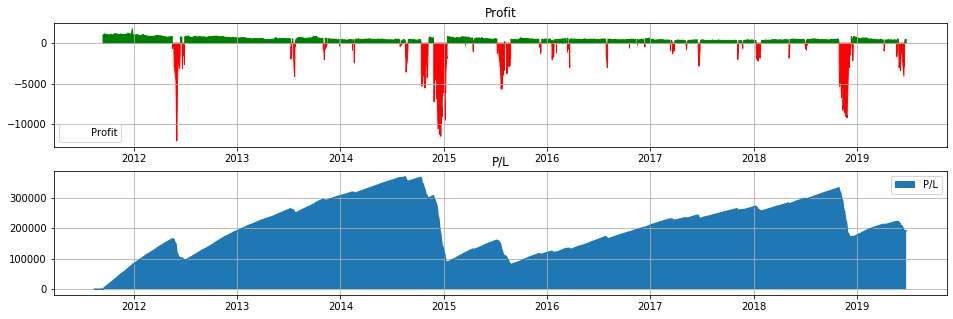

In [44]:
fig, axes = plt.subplots(2, figsize=(16,5))
x = sr_profit_const_30.index
y = sr_profit_const_30 * 1000
y_csum = y.cumsum()

# Plot 0
axes[0].plot(y, linewidth=0, label="Profit")
axes[0].fill_between(x, y, color='g', where=y > 0)
axes[0].fill_between(x, y, color='r', where=y < 0)
axes[0].set_title('Profit')

# Plot 1
axes[1].plot(y_csum)
axes[1].fill_between(x, y_csum, label="P/L")
axes[1].set_title('P/L')

for ax in axes.flat:
    ax.legend()
    ax.grid()

Results for daily simulation.

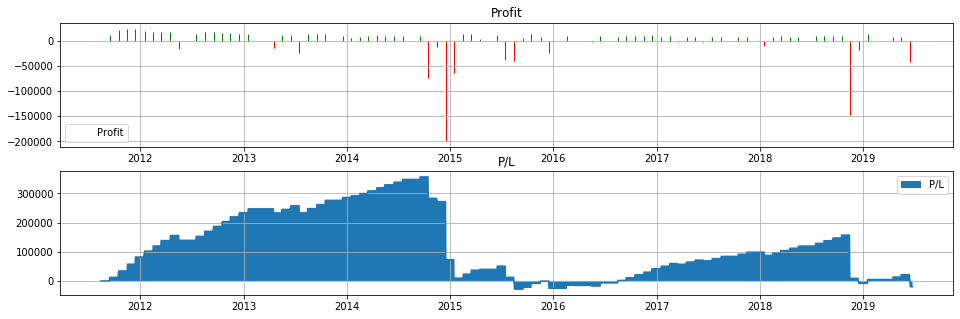

In [45]:
fig, axes = plt.subplots(2, figsize=(16,5))
x = sr_profit_standard.index
y = sr_profit_standard * 1000
y_csum = y.cumsum()

# Plot 0
axes[0].plot(y, linewidth=0, label="Profit")
axes[0].fill_between(x, y, color='g', where=y > 0)
axes[0].fill_between(x, y, color='r', where=y < 0)
axes[0].set_title('Profit')

# Plot 1
axes[1].plot(y_csum)
axes[1].fill_between(x, y_csum, label="P/L")
axes[1].set_title('P/L')

for ax in axes.flat:
    ax.legend()
    ax.grid()

The plots show that a simple strategy of holding a short strangle until expiration could have been a profitable strategy until end of 2014, and also between 2016 and end of 2018.